```
This software is part of GPU Ocean. 

Copyright (C) 2024 SINTEF Digital

Running the simplified ocean model from real-world initial conditions, 
including plotting, animation, and grid refinement and coarsening.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Real-world deterministic simulation 

This example shows how to
* one-way nest a simplified ocean model within a operational ocean forecast
* initialize a simplified ocean model simulation and run it
* run a simulation with coarser or finer grid resolution than the reference operational model
* plot (or animate) the simulation result in various ways

In [1]:
# Choose whether to animate the simulation results or simply plot them
create_movie = False
# Note: Please don't commit this notebook to git with animations.

We start by loading the required modules and set options for plotting

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import os
import tqdm
from IPython.display import display

#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'

In [3]:
# Import relevant modules from within GPU Ocean
from gpuocean.SWEsimulators import GPUOceanSim
from gpuocean.utils import IPythonMagic, NetCDFInitialization, PlotHelper

In [4]:
# Create the GPU context
%cuda_context_handler gpu_ctx

## Choose ocean forecast for one-way nesting

We use available ocean forecasts generated by 3D operational models to obtain 
* initial conditions, 
* boundary conditions, 
* bathymetry, 
* landmask, 
* geographical orientation, and 
* wind forcing.

These parameters and fields will be available from a netCDF file, either online or locally.

Here, we use the forecast for the NorKyst-800 model on 16th July 2019, available on the Thredds server hosted by the Norwegian Meteorological Institute.

In [5]:
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

We choose a subdomain by providing the grid indices for the lower left and upper right corners.

For convinience, we have pre-defined some subdomains from the NorKyst-800 model.

In [6]:
norkystSubdomains = NetCDFInitialization.getNorkystSubdomains()
for subdomain in norkystSubdomains:
    print(f"{subdomain['name']}:\t x={subdomain['x0']}:{subdomain['x1']}, y={subdomain['y0']}:{subdomain['y1']}")

casename = 'lofoten'

norwegian_sea:	 x=900:1400, y=600:875
lofoten:	 x=1400:1900, y=450:750
complete_coast:	 x=25:2575, y=25:875
skagerak:	 x=300:600, y=50:250
oslo:	 x=500:550, y=160:210
denmark:	 x=2:300, y=2:300
lovese:	 x=1400:2034, y=450:769


Select timesteps to be downloaded from the NetCDF file (optional)

Note: This is useful if you want to run a very short simulation of T < 24 hours. In this case, it is sufficient to download data for wind and boundary conditions only for T hours, and not for the entire duration of the NetCDF input file. The drawback, however, is that if you nonethereless run your simulation for longer than T hours, the boundary conditions won't make sense after t=T.

In [7]:
T_hours = 24
timestep_indices = [list(range(0,T_hours))]


The module `NetCDFInitialization` contains utility functions for translating the NetCDF file containing the results from the operational ocean forecast to parameters that are required for a GPU Ocean simulation.

Here, you can choose to download the operational NetCDF file for faster initialization next time, and to erode a certain number of grid cells from the land mask to better resolve currents in narrow straits.

In [8]:
sim_args = NetCDFInitialization.getInitialConditionsNorKystCases(source_url, casename, 
                                                                 download_data=False, erode_land=1, 
                                                                 timestep_indices=timestep_indices)


## Run GPU Ocean simulation

First, lets write a utility function for running the simulation, choosing the frequency of writing to the output file, etc

In [9]:
def runSim(sim, T_end, netcdf_freq=3600, sub_t=3600):
    
    # Assumptions for simplifying this demo:
    if sim.t > 0:
        print("simulation is already run")
        return
    assert T_end % netcdf_freq == 0, "This function assumes that T_end is a multiple of netcdf_freq"
    assert netcdf_freq % sub_t == 0, "This function assumes that netcdf_freq is a multiple of sub_t"

    for i in tqdm.tqdm(range(T_end // netcdf_freq)):
        for substep in range(netcdf_freq // sub_t):
            sim.step(sub_t)
            sim.updateDt()

    # If we want to read the output file within the same notebook as it was written, we need to close it manually first. 
    sim.closeNetCDF() 


Create the simulation object.

The simulator class name reflects the numerical method that is used, but for realistic simulation this method is in fact the only choice.

Provide filename for `netcdf_filename` (or set `write_netcdf=False`).

In [10]:
filename_sim = os.path.join("demoOutput", "minimal-original.nc")
if 'sim' in globals():
    sim.cleanUp()
sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(sim_args),
                     write_netcdf=True, netcdf_filename=filename_sim)


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Run the simulation using the utility function from before

In [11]:
runSim(sim, T_hours*3600)

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [01:45<00:00,  4.40s/it]


Closing file demoOutput\minimal-original.nc ...


## Plot results

All plotting functions used here show the variables in the simplified model, $\eta$, $hu$ and $hv$. By setting `add_extra=True`, however, we also plot particle velocity and vorticity magnitude.

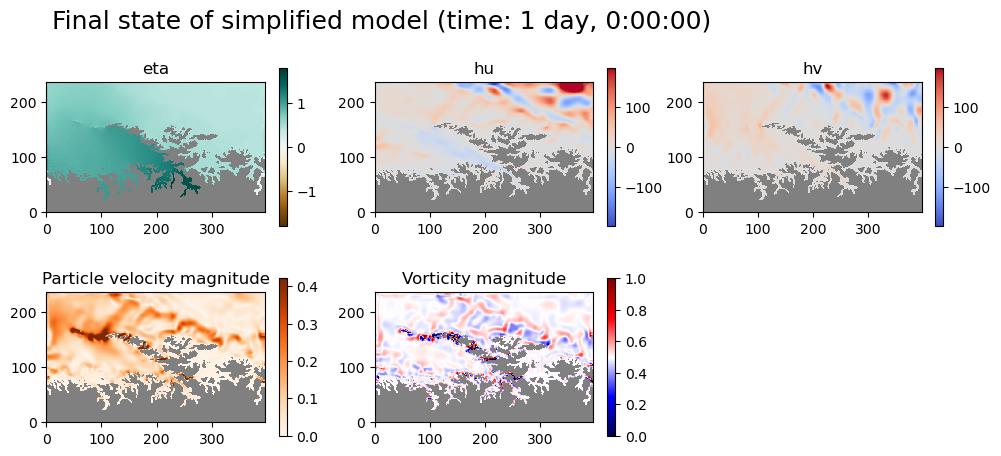

In [12]:
_, _ = PlotHelper.plotSim(sim, plot_title="Final state of simplified model", add_extra=True)

We can also read the resulting NetCDF and animate the solution

c:\Users\havardh\Miniconda3\envs\gpuocean-extra\lib\site-packages\matplotlib\colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


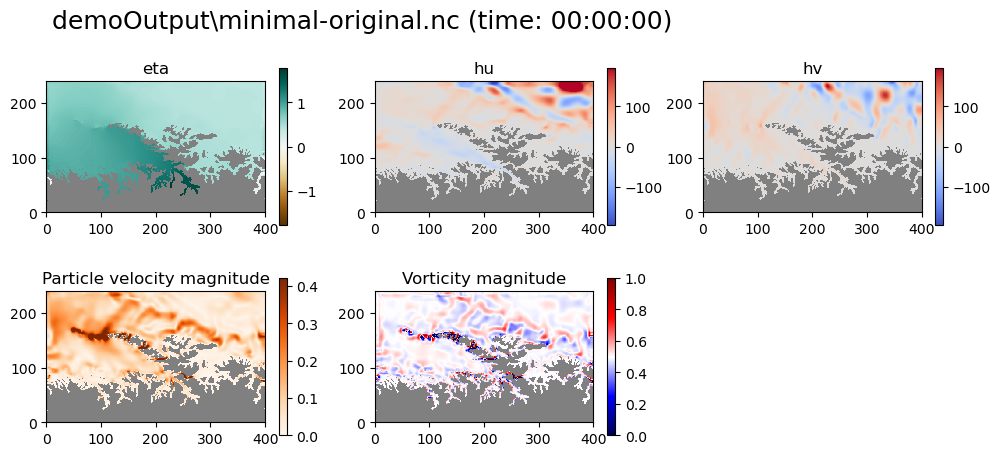

In [13]:
PlotHelper.ncAnimation(filename_sim, add_extra=True, create_movie=create_movie)

If you don't want to store the simulation results at all, you can use the following utility function to make an animation on the fly.

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


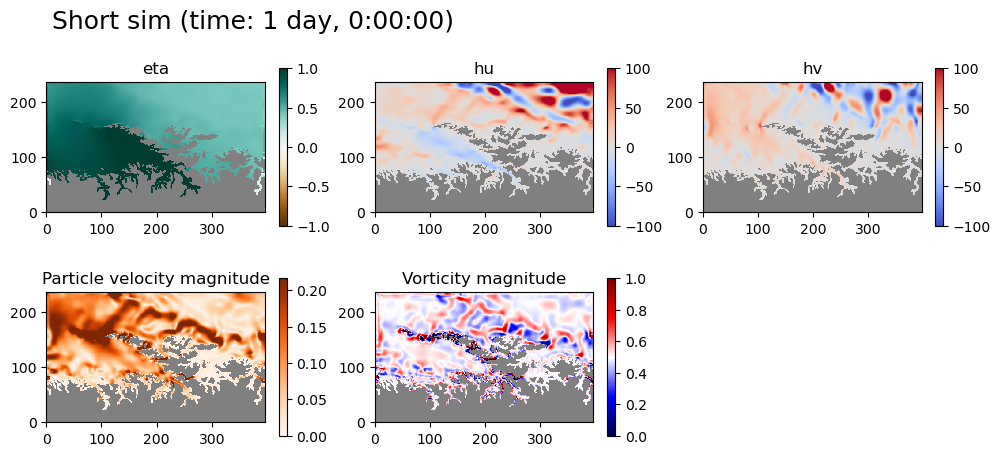

In [14]:
sim2 = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(sim_args))
PlotHelper.simAnimation(sim2, T_hours*3600, 3600, plot_title="Short sim", add_extra=True, create_movie=create_movie)
# Function signature is (sim, T_end, anim_dt, ...)

For reference, this function creates an animation (or just a plot) of the reference operational model

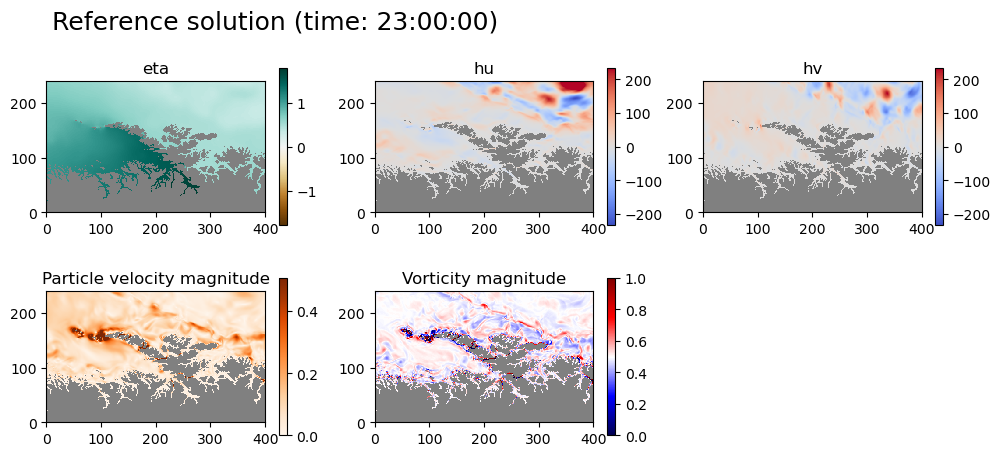

In [15]:
caseloc = NetCDFInitialization.getCaseLocation(casename)
PlotHelper.norkystAnimation(source_url, 
                            caseloc["x0"], caseloc["x1"], caseloc["y0"], caseloc["y1"], 
                            add_extra=True, create_movie=create_movie)

# Grid refinement

It is easy to change grid resolution for the simplified ocean models.
Here, we compare three simulations with both coarser and finer resolution along with the original resolution of the operational model.

For conviniency, we choose a shorter simulation time frame than before, but feel free to adjust these parameters.

In [16]:
T_hours = 3
timestep_indices = [list(range(0,T_hours))]

sim_args =  NetCDFInitialization.getInitialConditionsNorKystCases(source_url, casename, 
                                                                 download_data=False, erode_land=1, 
                                                                 timestep_indices=timestep_indices)

##### Coarse resolution

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


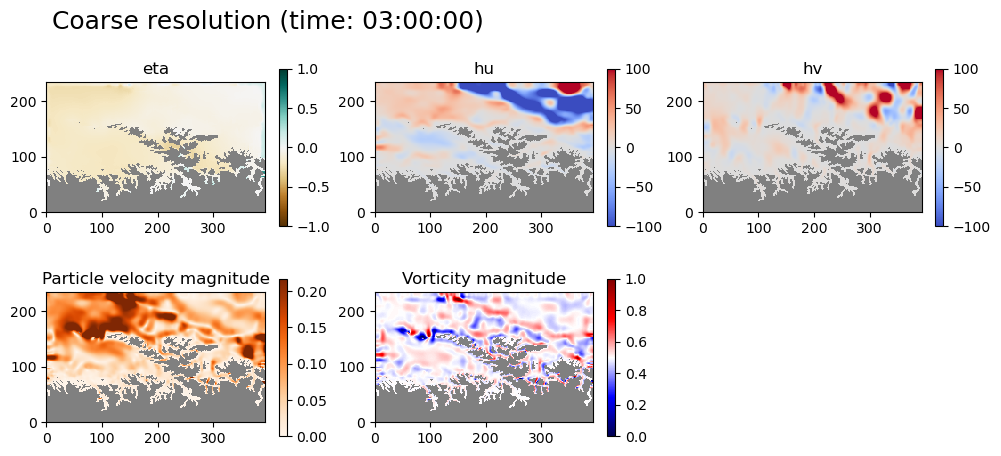

In [17]:
coarse_sim_args = NetCDFInitialization.rescaleInitialConditions(sim_args, 0.5)

coarse_sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(coarse_sim_args))
PlotHelper.simAnimation(coarse_sim, T_hours*3600, 600, plot_title="Coarse resolution", add_extra=True, create_movie=create_movie)


##### Original resolution

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


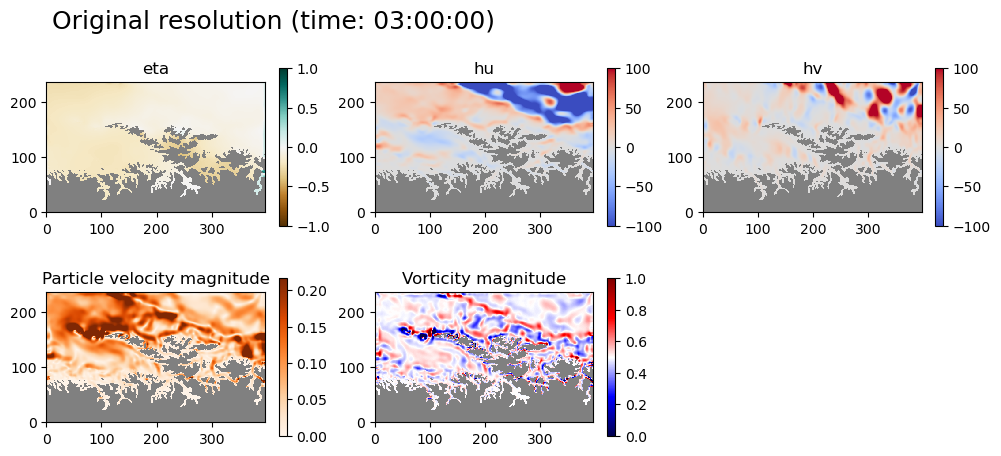

In [18]:
original_sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(sim_args))
PlotHelper.simAnimation(original_sim, T_hours*3600, 600, plot_title="Original resolution", add_extra=True, create_movie=create_movie)


##### Fine resolution

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


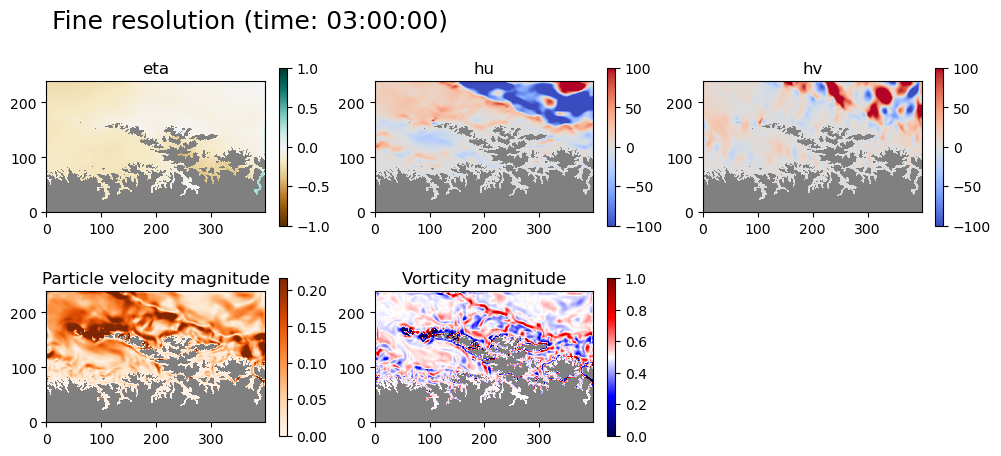

In [19]:
fine_sim_args = NetCDFInitialization.rescaleInitialConditions(sim_args, 2)

fine_sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(fine_sim_args))
PlotHelper.simAnimation(fine_sim, T_hours*3600, 600, plot_title="Fine resolution", add_extra=True, create_movie=create_movie)


##### Extra fine resolution

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


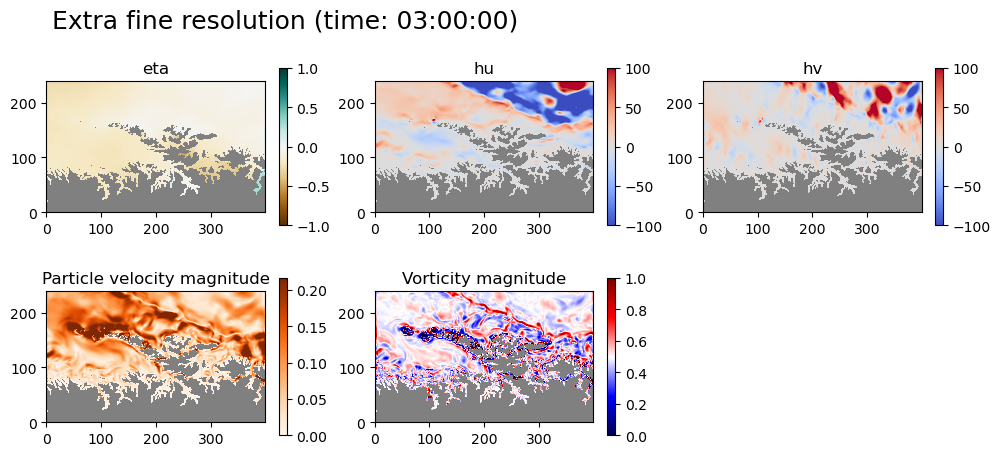

In [20]:
extra_fine_sim_args = NetCDFInitialization.rescaleInitialConditions(sim_args, 4)

extra_fine_sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(extra_fine_sim_args))
PlotHelper.simAnimation(extra_fine_sim, T_hours*3600, 600, plot_title="Extra fine resolution", add_extra=True, create_movie=create_movie)